In [95]:
import pathlib
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pathlib
from GPy.models import GPRegression
import GPy
import pickle
import matplotlib.colors as mcolors
from sklearn.neighbors import KernelDensity
import sys
sys.path.insert(0, "./../")
from src.ice_sheet import ice_sheet_runner
import random
from pathos.multiprocessing import ProcessingPool as Pool
import time
from src.utils import load_data, prep_data, predict_and_plot_SLC
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from pathos.multiprocessing import ProcessingPool as Pool
from scipy.stats import wasserstein_distance
from sklearn.utils import shuffle
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
from GPy.models import GPRegression
import GPy
from emukit.model_wrappers import GPyModelWrapper
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.acquisition.acquisition_per_cost import acquisition_per_expected_cost
from emukit.core.interfaces.models import IModel
from emukit.experimental_design import ExperimentalDesignLoop
import plotly.graph_objects as go
import itertools
from sklearn.svm import SVR
from src.utils import plot
import copy
from IPython.display import Video
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('colorblind')
mpl.rcParams['font.family'] = 'Arial'

In [96]:
data = load_data([0,151], datasets_folder="./../assets/v2_ice_sheet_simulation/", extension="_dt", version="vs")
start = 2
budget_list = []
for i in range(30):
    new_start = int(start * (1.5))
    if new_start - start > 500:
        start += 500
    else:
        start = new_start
    budget_list.append(start)
max_budget = budget_list[-1]
cost = {2:70,3:12,4:8,5:4,6:3,7:2,8:1}

In [97]:
max_budget = cost[2] * 4

In [98]:
def control_distribution(x, lower=2, upper=8, threshold=1.5):
    # Ensure x is within the valid range [0, 1]
    x = max(0.0, min(1.0, x))

    # Define the mean of the Gaussian based on x
    mean = lower + x * (upper - lower)

    # Values range from lower to upper
    values = np.arange(lower, upper + 1)

    # Compute Gaussian weights based on the defined mean
    weights = np.exp(-0.5 * ((values - mean) ** 2) / threshold**2)

    # Accumulate outliers into the nearest extreme values directly
    if lower + threshold > lower:
        accumulated_lower = weights[values < lower + threshold].sum()
        weights[0] += accumulated_lower  # Assume the first element corresponds to 'lower'

    if upper - threshold < upper:
        accumulated_upper = weights[values > upper - threshold].sum()
        weights[-1] += accumulated_upper  # Assume the last element corresponds to 'upper'

    # Normalizing weights
    weights /= weights.sum()

    # Sample from the distribution
    return np.random.choice(values, p=weights)


In [99]:
num_sample = 20
data_sub = data[data["years"] == 150]
X_m = np.hstack([np.linspace(0,150,7).reshape((-1, 1)), np.arange(2, 9).reshape((-1, 1))])
print(data_sub, X_m)
X, Y, X_m = prep_data(data_sub, include_res=True,X_m=X_m)

X_sub = X[:num_sample]
Y_sub = Y[:num_sample]


# Boiler plate for plotting
mesh_size = 50
space = ParameterSpace([ContinuousParameter('Resolution', X[:,0].min(), X[:,0].max()),
                        ContinuousParameter('Melt Average', X[:,1].min(), X[:,1].max())])

corners = np.array([[X[:,0].min(), X[:,1].min()],
                    [X[:,0].min(), X[:,1].max()],
                    [X[:,0].max(), X[:,1].min()],
                    [X[:,0].max(), X[:,1].max()]])



kernel = GPy.kern.RBF(input_dim=2,ARD=True,lengthscale=[1,1],variance=1)
model_gpy = GPRegression(X_sub,Y_sub,kernel = kernel,normalizer=True,noise_var=0.05)
model_gpy.parameters[0].variance.fix()
model_gpy.parameters[1].variance.fix()

x_monte_carlo = np.vstack([
                np.linspace(X[:,0].min(),X[:,0].max(),mesh_size),
                np.ones((mesh_size))*space.parameters[1].min,]).T
model_emukit = GPyModelWrapper(model_gpy)
model_variance = IntegratedVarianceReduction(model=model_emukit,space=space,x_monte_carlo=x_monte_carlo)
class CostModel(IModel):
    def __init__(self,cost):
        self.cost = cost

    def predict(self, X: np.ndarray):
        cost_dict = self.cost
        keys = np.array(list(cost_dict.keys()))
        values = np.array(list(cost_dict.values()))
        sorted_indices = np.argsort(keys)
        sorted_keys = keys[sorted_indices]
        sorted_values = values[sorted_indices]
        costs = np.interp(X[:, 1], sorted_keys, sorted_values).reshape((-1, 1))
        return (costs, X)

cost_model = CostModel({x[1]: cost[idx+2] for idx, x in enumerate(X_m)}) # Fit a linear model on the costs
weighted_variance = acquisition_per_expected_cost(model_variance,cost_model)
for _,res in X_m:
    x_monte_carlo = np.vstack([
                np.linspace(X[:,0].min(),X[:,0].max(),mesh_size),
                np.ones((mesh_size))*res]).T

    utility = model_variance.evaluate(x_monte_carlo)

    weighted_utility = weighted_variance.evaluate(x_monte_carlo)
    print(res, np.array(utility).mean(), np.array(weighted_utility).mean())

        index  melt_exp  melt_average  melt_partial         SLC  resolution  \
15600       0       2.0           0.0           0.0   45.678647           2   
15601       1       2.0           0.0           0.0   33.907613           2   
15602       2       2.0           0.0           0.0   32.436782           2   
15603       3       2.0           0.0           0.0   55.983603           2   
15604       4       2.0           0.0           0.0   49.279017           2   
...       ...       ...           ...           ...         ...         ...   
149183    203       2.0         150.0           0.0  267.822219           8   
149184    204       2.0         150.0           0.0  257.421129           8   
149185    205       2.0         150.0           0.0  214.625579           8   
149186    206       2.0         150.0           0.0  213.467506           8   
149187    207       2.0         150.0           0.0  157.933915           8   

        years  
15600     150  
15601     150  
156

In [143]:
def mfed_selection(data_sub, X_m):
    X_m = np.hstack([np.zeros((7,1)), np.arange(2, 9).reshape((-1, 1))])
    X, Y, X_m = prep_data(data_sub, include_res=True,X_m=X_m)
    X_sub = X
    Y_sub = Y
    # Boiler plate for plotting
    mesh_size = 50
    space = ParameterSpace([ContinuousParameter('Resolution', X[:,0].min(), X[:,0].max()),
                            ContinuousParameter('Melt Average', X[:,1].min(), X[:,1].max())])



    kernel = GPy.kern.RBF(input_dim=2,ARD=True,lengthscale=[1,1],variance=1)
    model_gpy = GPRegression(X_sub,Y_sub,kernel = kernel,normalizer=True,noise_var=0.05)
    model_gpy.parameters[0].variance.fix()
    model_gpy.parameters[1].variance.fix()

    x_monte_carlo = np.vstack([
                    np.linspace(X[:,0].min(),X[:,0].max(),mesh_size),
                    np.ones((mesh_size))*space.parameters[1].min,]).T
    model_emukit = GPyModelWrapper(model_gpy)
    model_variance = IntegratedVarianceReduction(model=model_emukit,space=space,x_monte_carlo=x_monte_carlo)
    class CostModel(IModel):
        def __init__(self,cost):
            self.cost = cost

        def predict(self, X: np.ndarray):
            cost_dict = self.cost
            keys = np.array(list(cost_dict.keys()))
            values = np.array(list(cost_dict.values()))
            sorted_indices = np.argsort(keys)
            sorted_keys = keys[sorted_indices]
            sorted_values = values[sorted_indices]
            costs = np.interp(X[:, 1], sorted_keys, sorted_values).reshape((-1, 1))
            return (costs, X)

    cost_model = CostModel({x[1]: cost[idx+2] for idx, x in enumerate(X_m)}) # Fit a linear model on the costs
    weighted_variance = acquisition_per_expected_cost(model_variance,cost_model)
    weighted_utility = {}
    for idx,(_,res) in enumerate(X_m):
        x_monte_carlo = np.vstack([
                    np.linspace(X[:,0].min(),X[:,0].max(),mesh_size),
                    np.ones((mesh_size))*res]).T

        weighted_utility[idx+2] = np.array(weighted_variance.evaluate(x_monte_carlo)).mean()
    return weighted_utility


In [144]:
def sample_points_res(data_sub, res_list, X_m):
    closest_points = []
    #print(data_list)
    for idx, res in enumerate(res_list):
        x_m_value = random.choice(X_m)
        data_tmp = data_sub[data_sub["resolution"] == res]
        closest_point_index = (data_tmp['melt_average'] - x_m_value).abs().argsort()[:1].values[0]
        closest_points.append(data_tmp.iloc[closest_point_index])
    return closest_points

In [154]:
def point_selection_algo(data_sub, resolution, budget, X_m, prev_val):
    match resolution:
        case "average":
            coef = 1-(budget / max_budget)
            tmp_budget = budget - sum([cost[i] for i in prev_val])
            while tmp_budget > 0:
                min_lower = min(cost.keys(), key=lambda x: abs(cost[x] - tmp_budget))
                sample = control_distribution(coef, lower=min_lower)
                prev_val.append(sample)
                tmp_budget -= cost[sample]
                if len(prev_val) > 500:
                    break
            closest_points = sample_points_res(data_sub, prev_val, X_m)
            if len(closest_points) < 2:
                return None, None
            closest_points = pd.DataFrame(closest_points)
        case "mfed":

            closest_points = pd.DataFrame(sample_points_res(data_sub, prev_val +[2,4,8], X_m))
            weighted_utility = mfed_selection(closest_points, X_m)
            tmp_budget = budget - sum([cost[i] for i in prev_val])
            while tmp_budget > 0:
                sample = max((k for k, v in cost.items() if v <= tmp_budget), key=lambda x: weighted_utility[x], default=None)
                tmp_budget -= cost[sample]
                prev_val.append(sample)
            closest_points = sample_points_res(data_sub, prev_val, X_m)
            if len(closest_points) < 2:
                return None, None
            closest_points = pd.DataFrame(closest_points)
        case 2 | 4  | 8:
            num_points = budget//cost[resolution]
            if num_points < 2:
                return None, None
            if num_points > 500:
                num_points = 500
            data_sub = data_sub[data_sub["resolution"] == resolution]
            closest_points_indices = []
            for x_m_value in X_m[:num_points].flatten():
                closest_point_index = (data_sub['melt_average'] - x_m_value).abs().argsort()[:1]
                closest_points_indices.append(closest_point_index.values[0])
            closest_points = data_sub.iloc[closest_points_indices]
    return closest_points, prev_val

In [155]:
def calculate_optimal_density(data, comp_budget, prev_val, resolution=2, mean_melt=2.2):
    data_sub = data[data["years"] == 150]
    X_m = np.random.lognormal(mean=mean_melt, size=500).reshape(
        (-1, 1)
    )
    closest_points, prev_val = point_selection_algo(data_sub, resolution, comp_budget, X_m,prev_val)
    if closest_points is None:
        return None
    X, Y, X_m = prep_data(closest_points, X_m=X_m)
    kernel = GPy.kern.RBF(input_dim=1, ARD=True, lengthscale=[1], variance=1)
    model_gpy = GPRegression(X, Y, kernel=kernel, normalizer=True, noise_var=1)
    model_gpy.optimize()
    mean,var  = model_gpy.predict(X_m.reshape((-1, 1)))
    data_list = []
    size = 500 // len(mean)
    for m,v in zip(mean,var):
        data_list += list(np.random.normal(m,np.sqrt(v),size=size))

    X_lin = np.linspace(0,500,100)[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian',bandwidth=1).fit(np.array(data_list).reshape((-1,1))) #you can supply a bandwidth

    log_density_values=kde.score_samples(X_lin)
    y_opt_pdf=np.exp(log_density_values)
    # Calculate optimal CDF
    max_val = 400
    x = []
    y = []
    for thres in range(0,max_val,5):
        # Count how many elements in data list are abov thres
        # and divide by the total number of elements
        # to get the percentage of elements above thres
        x.append(thres)
        y.append(len([i for i in data_list if i > thres])/len(data_list))
    y_opt_cdf = np.array(y)
    return y_opt_cdf, y_opt_pdf, data_list, prev_val

In [162]:
mean_errors = {}
pdf_errors = {}
dt_list = {}
num_rep = 20
for mean_melt, melt_label in [(2.2,10),(2.872,20)]: #,
    opt_cdf,opt_pdf, observed_2k,_ = calculate_optimal_density(data, budget_list[-1], prev_val, resolution=2, mean_melt=mean_melt)
    mean_errors[melt_label] = {}
    pdf_errors[melt_label] = {}
    dt_list[melt_label] = {}
    for res in ["mfed", "average",2,4,8]: #,
        #if res == "mfed":
        #    prev_val = [2,4,8]
        prev_val = []
        new_val = []
        mean_errors[melt_label][res] = {}
        pdf_errors[melt_label][res] = {}
        dt_list[melt_label][res] = {}
        for budget in budget_list[:24]:
            errors = []
            pdf_error_list = []
            for _ in range(num_rep):
                result = calculate_optimal_density(data, budget, prev_val, resolution=res, mean_melt=mean_melt)
                if result is not None:
                    y_opt_cdf, new_pdf, new_observed, new_val = result
                else:
                    continue
                pdf_error_list.append(np.abs(opt_pdf-new_pdf).sum())
                errors.append(wasserstein_distance(observed_2k, new_observed))
            if new_val is not None:
                prev_val = new_val
            mean_errors[melt_label][res][budget] = errors
            pdf_errors[melt_label][res][budget] = pdf_error_list
            dt_list[melt_label][res][budget] = prev_val
            print(f"Resolution: {res}, Budget: {budget}, Mean Error: {np.array(pdf_errors[melt_label][res][budget]).mean()}, mean dt: {np.array(dt_list[melt_label][res][budget]).mean()}")


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: mfed, Budget: 3, Mean Error: nan, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: mfed, Budget: 4, Mean Error: nan, mean dt: 5.0
Resolution: mfed, Budget: 6, Mean Error: 0.22259339447863571, mean dt: 6.0
Resolution: mfed, Budget: 9, Mean Error: 0.19390128541811322, mean dt: 6.0
Resolution: mfed, Budget: 13, Mean Error: 0.19409457606793223, mean dt: 5.75
Resolution: mfed, Budget: 19, Mean Error: 0.17152388838960642, mean dt: 5.833333333333333
Resolution: mfed, Budget: 28, Mean Error: 0.14754485068921236, mean dt: 5.875
Resolution: mfed, Budget: 42, Mean Error: 0.16167885270307905, mean dt: 6.0
Resolution: mfed, Budget: 63, Mean Error: 0.1590870724928533, mean dt: 5.785714285714286
Resolution: mfed, Budget: 94, Mean Error: 0.15922309367015103, mean dt: 5.444444444444445
Resolution: mfed, Budget: 141, Mean Error: 0.15267986999266414, mean dt: 5.086956521739131
Resolution: mfed, Budget: 211, Mean Error: 0.14246148188166224, mean dt: 4.766666666666667
Resolution: mfed, Budget: 316, Mean Error: 0.13816270798502825, mean dt: 4.9298245614035086
Resolution: mfed,

 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide
 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: average, Budget: 6, Mean Error: 0.2248697475774363, mean dt: 6.0
Resolution: average, Budget: 9, Mean Error: 0.19853571906088144, mean dt: 7.2
Resolution: average, Budget: 13, Mean Error: 0.18645699427142245, mean dt: 7.555555555555555
Resolution: average, Budget: 19, Mean Error: 0.17935607417603977, mean dt: 7.416666666666667
Resolution: average, Budget: 28, Mean Error: 0.1742532192904916, mean dt: 7.133333333333334
Resolution: average, Budget: 42, Mean Error: 0.1845399269134579, mean dt: 7.173913043478261
Resolution: average, Budget: 63, Mean Error: 0.1856021290267576, mean dt: 7.147058823529412
Resolution: average, Budget: 94, Mean Error: 0.17575289028187024, mean dt: 6.953488372093023
Resolution: average, Budget: 141, Mean Error: 0.17119182558035742, mean dt: 6.709090909090909
Resolution: average, Budget: 211, Mean Error: 0.1685851245969783, mean dt: 6.52542372881356
Resolution: average, Budget: 316, Mean Error: 0.16012012260558645, mean dt: 6.370967741935484
Resolution

 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11

Resolution: 2, Budget: 141, Mean Error: 0.2714304437733971, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 2, Budget: 211, Mean Error: 0.15291718501922985, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 2, Budget: 316, Mean Error: 0.13982500331067227, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 2, Budget: 474, Mean Error: 0.10998843272874541, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 2, Budget: 711, Mean Error: 0.08608673966941746, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 2, Budget: 1066, Mean Error: 0.07188552048362497, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 2, Budget: 1566, Mean Error: 0.08023963737439359, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 2, Budget: 2066, Mean Error: 0.06794868719385988, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 2, Budget: 2566, Mean Error: 0.07292430142452166, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 2, Budget: 3066, Mean Error: 0.07109305998519776, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 2, Budget: 3566, Mean Error: 0.07556870139769337, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 2, Budget: 4066, Mean Error: 0.07463096449989788, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 2, Budget: 4566, Mean Error: 0.0758772297088571, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 2, Budget: 5066, Mean Error: 0.07363670645392296, mean dt: nan
Resolution: 4, Budget: 3, Mean Error: nan, mean dt: nan
Resolution: 4, Budget: 4, Mean Error: nan, mean dt: nan
Resolution: 4, Budget: 6, Mean Error: nan, mean dt: nan
Resolution: 4, Budget: 9, Mean Error: nan, mean dt: nan
Resolution: 4, Budget: 13, Mean Error: nan, mean dt: nan


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 4, Budget: 19, Mean Error: 0.20898251872845827, mean dt: nan


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 4, Budget: 28, Mean Error: 0.19504964597921987, mean dt: nan


 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/GPy/util/normalizer.py:94: UserWarning:Some values of Y have standard deviation of zero. Resetting to 1.0 to avoid divide by zero errors.
 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 4, Budget: 42, Mean Error: 0.1670241412075667, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 4, Budget: 63, Mean Error: 0.15125763141303877, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 4, Budget: 94, Mean Error: 0.1257311551077261, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 4, Budget: 141, Mean Error: 0.1352893655534615, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 4, Budget: 211, Mean Error: 0.11947010836006688, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 4, Budget: 316, Mean Error: 0.12387394931210852, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 4, Budget: 474, Mean Error: 0.12637182116227402, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 4, Budget: 711, Mean Error: 0.1208260263298266, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 4, Budget: 1066, Mean Error: 0.12367322108274197, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 4, Budget: 1566, Mean Error: 0.12229961024931764, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 4, Budget: 2066, Mean Error: 0.12465984351445498, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 4, Budget: 2566, Mean Error: 0.1252974494319365, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 4, Budget: 3066, Mean Error: 0.12425146868022056, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 4, Budget: 3566, Mean Error: 0.1241265711250259, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 4, Budget: 4066, Mean Error: 0.12295990722629127, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 4, Budget: 4566, Mean Error: 0.12757432387734777, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 4, Budget: 5066, Mean Error: 0.12193015596364269, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 3, Mean Error: 0.2287541166081423, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 4, Mean Error: 0.22850296206686607, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 6, Mean Error: 0.23729105182650184, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 9, Mean Error: 0.21699227313804687, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 13, Mean Error: 0.2049974629365133, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 19, Mean Error: 0.1874711077918998, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 28, Mean Error: 0.18651456839901454, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 42, Mean Error: 0.18639319295317508, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 63, Mean Error: 0.17411806580498698, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 94, Mean Error: 0.17315695804642756, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 141, Mean Error: 0.17199666622512141, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 211, Mean Error: 0.16465769452592435, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 316, Mean Error: 0.16650835529204874, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 474, Mean Error: 0.16575422422995675, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 711, Mean Error: 0.16795360109277396, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 1066, Mean Error: 0.16756895921998471, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 1566, Mean Error: 0.16959688507073137, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 2066, Mean Error: 0.16665584191276656, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 2566, Mean Error: 0.16362613803166426, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 3066, Mean Error: 0.16704118125382644, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 3566, Mean Error: 0.1714437010530709, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 4066, Mean Error: 0.16832295780419915, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 4566, Mean Error: 0.1675351240959629, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: 8, Budget: 5066, Mean Error: 0.16843080793247117, mean dt: nan


 /var/folders/z6/989ctq0d7vg21wbnl9sb_yh80000gn/T/ipykernel_38710/1726108596.py:34: RuntimeWarning:Mean of empty slice.
 /Users/pierrethodoroff/miniconda3/envs/ice_sheet/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide


Resolution: mfed, Budget: 3, Mean Error: nan, mean dt: nan
Resolution: mfed, Budget: 4, Mean Error: 0.2311893138436373, mean dt: 7.0
Resolution: mfed, Budget: 6, Mean Error: 0.1955608615714977, mean dt: 7.0
Resolution: mfed, Budget: 9, Mean Error: 0.17562965987506388, mean dt: 6.75
Resolution: mfed, Budget: 13, Mean Error: 0.1779869612942933, mean dt: 6.4
Resolution: mfed, Budget: 19, Mean Error: 0.15701764186574063, mean dt: 6.285714285714286
Resolution: mfed, Budget: 28, Mean Error: 0.14474557176551156, mean dt: 6.222222222222222
Resolution: mfed, Budget: 42, Mean Error: 0.15011039548083274, mean dt: 6.0
Resolution: mfed, Budget: 63, Mean Error: 0.14192788273980622, mean dt: 5.785714285714286
Resolution: mfed, Budget: 94, Mean Error: 0.135213919678903, mean dt: 5.444444444444445
Resolution: mfed, Budget: 141, Mean Error: 0.13261075231382216, mean dt: 5.086956521739131
Resolution: mfed, Budget: 211, Mean Error: 0.12653775890271318, mean dt: 4.9375
Resolution: mfed, Budget: 316, Mean E

KeyboardInterrupt: 

In [132]:
budget_list

[3,
 4,
 6,
 9,
 13,
 19,
 28,
 42,
 63,
 94,
 141,
 211,
 316,
 474,
 711,
 1066,
 1566,
 2066,
 2566,
 3066,
 3566,
 4066,
 4566,
 5066,
 5566,
 6066,
 6566,
 7066,
 7566,
 8066]

         res  budget  melt_label     error
0  averagekm       3          10  0.273538
1  averagekm       6          10  0.309100
2  averagekm       9          10  0.258768
3  averagekm      13          10  0.242348
4  averagekm      19          10  0.129047
10
./../assets/plots/fig_7/comp_10.pdf


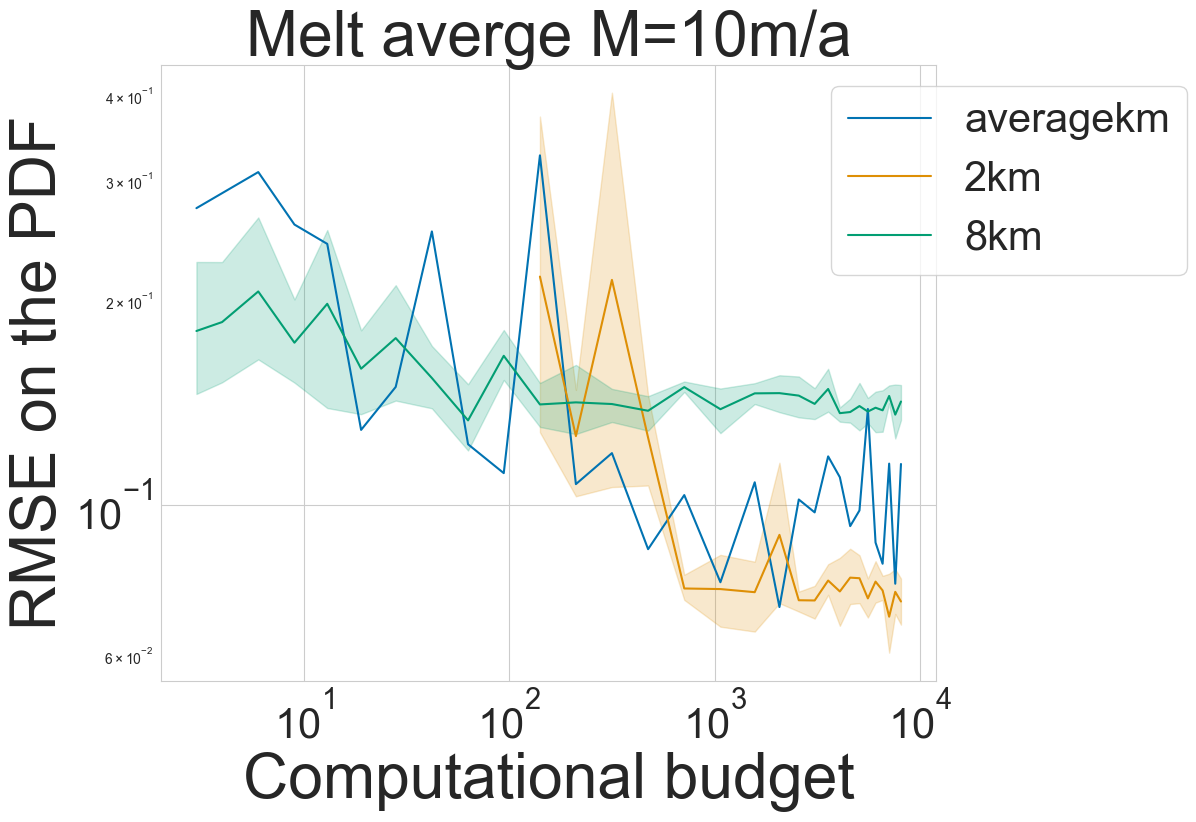

In [17]:
import pandas as pd

# Initialize an empty list to store the data
data_for_df = []

# Iterate through the pdf_errors dictionary to extract the necessary information
for melt_label, res_dict in pdf_errors.items():
    for res, budget_dict in res_dict.items():
        for budget, error_list in budget_dict.items():
            # For each error in the error_list, append a new record to the list
            if error_list is not None:
                for error in error_list:
                    data_for_df.append({
                        "res": str(res)+"km",
                        "budget": budget,
                        "melt_label": melt_label,
                        "error": error
                    })

# Convert the list of data into a pandas DataFrame
pdf_errors_df = pd.DataFrame(data_for_df)

# Display the first few rows of the DataFrame to verify
print(pdf_errors_df.head())


sns.set_palette('colorblind')
sns.set_style('whitegrid')
mpl.rcParams['font.family'] = 'Arial'
for label in pdf_errors_df['melt_label'].unique():
    print(label)
    plt.figure(figsize=(10,8))
    sns.lineplot(data=pdf_errors_df[pdf_errors_df['melt_label'] == label], x="budget", y="error", hue="res")
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel("Computational budget", fontsize=45)
    plt.ylabel("RMSE on the PDF", fontsize=45)
    plt.legend(bbox_to_anchor=(1.35, 1), loc='upper right', fontsize=30, title_fontsize=45)
    plt.title(f"Melt averge M={label}m/a", fontsize=45)
    path = f"./../assets/plots/fig_7/comp_{str(label)}.pdf"
    print(path)
    plt.savefig(path,bbox_inches='tight')
    #plt.show()

In [10]:
import pickle
pdf_errors = {10:{}, 20:{}}
for melt_rate,melt_label in zip([10,20], ["low","high"]): #, "high"
    data_list = []
    for resolution in ["mfed", "average", 2,4,8]:
        tmp = pickle.load(open(f"./../assets/plots_data/fig_7/{melt_label}_{resolution}.pkl", 'rb'))
        pdf_errors[melt_rate][resolution] = tmp["pdf_errors"][melt_rate][resolution]
        #param_list.append()


dict_keys(['mean_errors', 'pdf_errors', 'dt_list'])
dict_keys(['mean_errors', 'pdf_errors', 'dt_list'])
dict_keys(['mean_errors', 'pdf_errors', 'dt_list'])
dict_keys(['mean_errors', 'pdf_errors', 'dt_list'])
dict_keys(['mean_errors', 'pdf_errors', 'dt_list'])
dict_keys(['mean_errors', 'pdf_errors', 'dt_list'])
dict_keys(['mean_errors', 'pdf_errors', 'dt_list'])
dict_keys(['mean_errors', 'pdf_errors', 'dt_list'])
dict_keys(['mean_errors', 'pdf_errors', 'dt_list'])
dict_keys(['mean_errors', 'pdf_errors', 'dt_list'])


dict_keys([10])

      res  budget  melt_label     error
0  mfedkm       4          10  0.311276
1  mfedkm       4          10  0.254059
2  mfedkm       4          10  0.310019
3  mfedkm       4          10  0.163247
4  mfedkm       4          10  0.161550
10
./../assets/plots/fig_7/comp_10.pdf
20
./../assets/plots/fig_7/comp_20.pdf


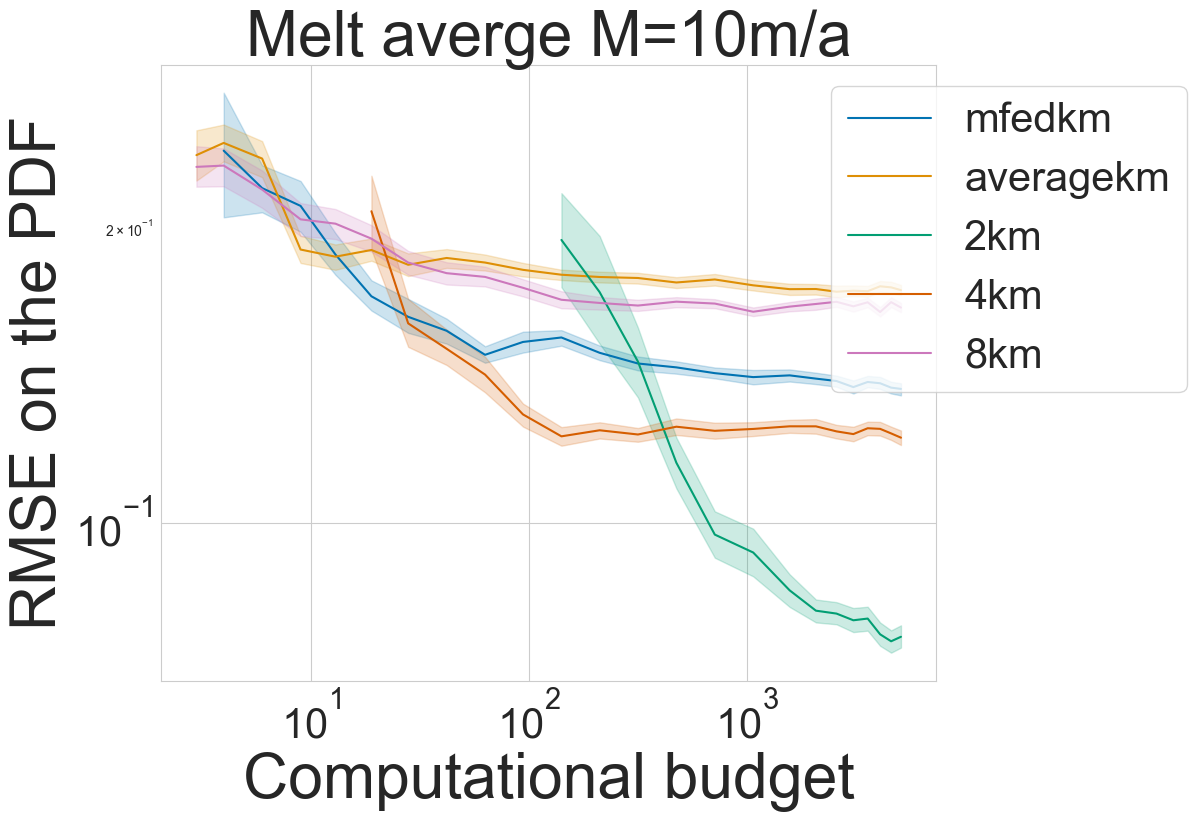

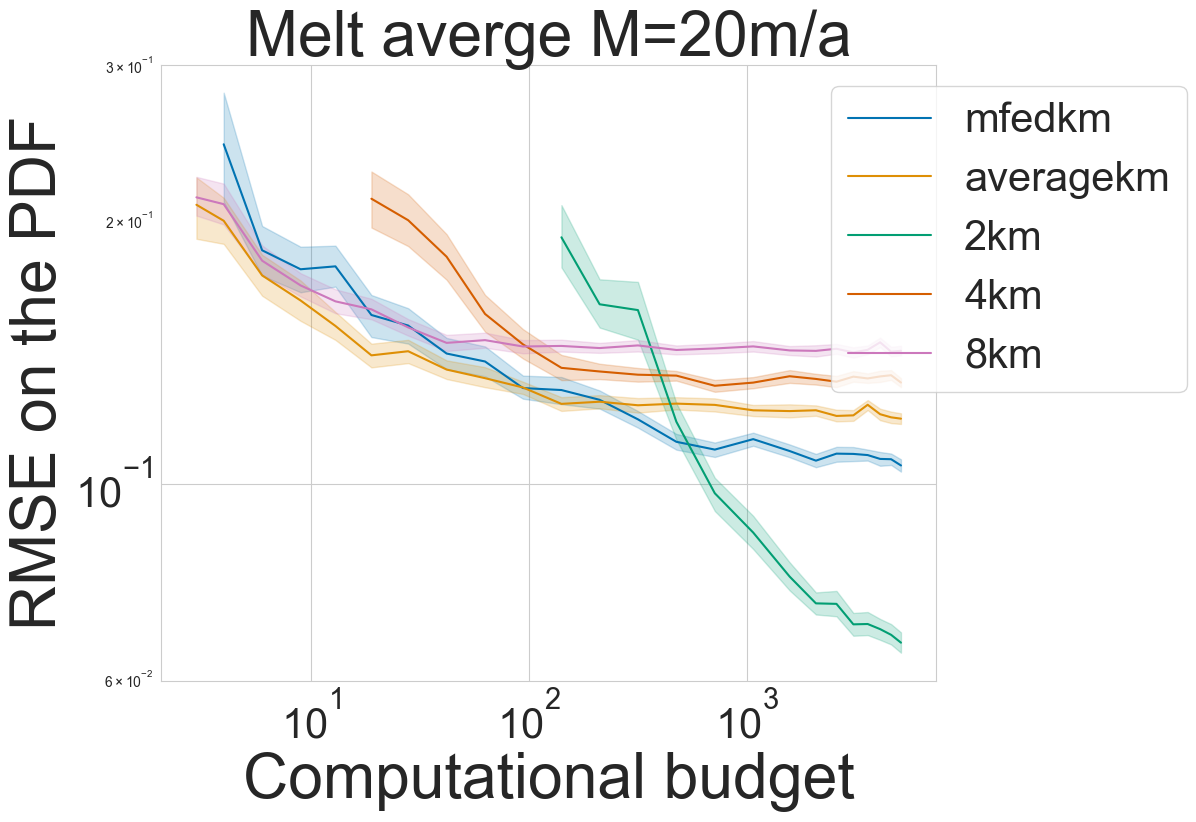

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import maptlotlib.pyplot as plt
# Initialize an empty list to store the data
data_for_df = []

# Iterate through the pdf_errors dictionary to extract the necessary information
for melt_label, res_dict in pdf_errors.items():
    for res, budget_dict in res_dict.items():
        for budget, error_list in budget_dict.items():
            # For each error in the error_list, append a new record to the list
            if error_list is not None:
                for error in error_list:
                    data_for_df.append({
                        "res": str(res)+"km",
                        "budget": budget,
                        "melt_label": melt_label,
                        "error": error
                    })

# Convert the list of data into a pandas DataFrame
pdf_errors_df = pd.DataFrame(data_for_df)

# Display the first few rows of the DataFrame to verify
print(pdf_errors_df.head())


sns.set_palette('colorblind')
sns.set_style('whitegrid')
mpl.rcParams['font.family'] = 'Arial'
for label in pdf_errors_df['melt_label'].unique():
    print(label)
    plt.figure(figsize=(10,8))
    sns.lineplot(data=pdf_errors_df[pdf_errors_df['melt_label'] == label], x="budget", y="error", hue="res")
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel("Computational budget", fontsize=45)
    plt.ylabel("RMSE on the PDF", fontsize=45)
    plt.legend(bbox_to_anchor=(1.35, 1), loc='upper right', fontsize=30, title_fontsize=45)
    plt.title(f"Melt averge M={label}m/a", fontsize=45)
    path = f"./../assets/plots/fig_7/comp_{str(label)}.pdf"
    print(path)
    plt.savefig(path,bbox_inches='tight')
    #plt.show()

In [ ]:
    corners = np.array([[X[:,0].min(), X[:,1].min()],
                        [X[:,0].min(), X[:,1].max()],
                        [X[:,0].max(), X[:,1].min()],
                        [X[:,0].max(), X[:,1].max()]])

